In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from  sklearn.preprocessing import label_binarize
import shap
import datetime
from sklearn.datasets import make_hastie_10_2
import logging
import sys

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [3]:
plots_dir = "plots"

In [4]:
# File paths for signal and background root files: 
electron_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200gen_filtered.h5"
electron_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200cl3d_filtered.h5"
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200cl3d_filtered.h5"
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCD20to120gen_filtered.h5"
qcd_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCD20to120cl3d_filtered.h5"
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/gen_filtered_neutrino.h5"
pions200PU_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200gen_filtered.h5"
pions200PU_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200cl3d_filtered.h5"

In [5]:
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)

In [6]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    """Filter DataFrame to keep only the highest-energy match per event within the delta R threshold."""
    required_columns = ['cl3d_eta', 'cl3d_phi', 'genpart_exeta', 'genpart_exphi', 'cl3d_energy', 'event']

    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    df = df.copy()  # Avoid modifying original DataFrame
    # Filter to keep only clusters with cl3d_energy > 0
    df = df[df['cl3d_ienergy'] > 0]
    # Compute delta_r
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    # Filter based on delta_r threshold
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    # Sort by event_id, cl3d_energy (descending), delta_r (ascending)
    df_sorted = df_filtered.sort_values(by=['event', 'cl3d_energy', 'delta_r'], ascending=[True, False, True])
    # Keep only the first occurrence per event_id
    df_best_match = df_sorted.groupby('event').first().reset_index()
    return df_best_match

In [7]:
# Function to load and filter the tree data (for HDF file)
def load_and_filter_hdf(df_gen_path, df_cl3d_path):
    if df_gen_path == 'None':
        df_cl3d = pd.read_hdf(df_cl3d_path)
        return df_cl3d 
 
    else:
        df_gen = pd.read_hdf(df_gen_path)
        df_cl3d = pd.read_hdf(df_cl3d_path)
        merged_df = pd.merge(
            df_gen,
            df_cl3d,
            on="event",
            how="inner",  # Keep only rows where the event ID exists in both
            suffixes=('_gen', '_cl3d')  # Differentiate common column names
        )
        return merged_df

In [8]:
def calculate_partial_auc(y_true, y_pred_probs, tpr_min, tpr_max):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    valid_idx = (tpr >= tpr_min) & (tpr <= tpr_max)
    partial_auc = auc(fpr[valid_idx], tpr[valid_idx])
    return partial_auc

def plot_roc_curve(y_true, y_pred_probs, threshold):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
    valid_idx = tpr > threshold
    plt.fill_between(fpr[valid_idx], tpr[valid_idx], color='orange', alpha=0.3, label=f'Signal efficiency > {threshold}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.yscale('log')
    plt.xscale('log')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    filename = os.path.join(plots_dir,f"roc_curve.png")
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")
    plt.show()
    plt.close()

In [9]:
electronPU200_df = load_and_filter_hdf(electron_PU200_gen, electron_PU200_cl3d)
photonPU200_df = load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)
neutrinoPU200_df = load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [10]:
pionsPU200_df = load_and_filter_hdf(pions200PU_gen, pions200PU_cl3d)

In [11]:
qcdPU200_df = pd.read_hdf("/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/output_matched.h5", key="matched")

In [12]:
#electronPU200_df_filtered = filter_by_delta_r(electronPU200_df)
photonPU200_df_filtered = filter_by_delta_r(photonPU200_df)

In [13]:
pionsPU200_df_filtered = filter_by_delta_r(pionsPU200_df)

In [14]:
# Get the common columns between signal and background DataFrames
common_columns = photonPU200_df_filtered.columns.intersection(pionsPU200_df.columns)
pionsPU200_df_final = pionsPU200_df[common_columns]
photonPU200_df_final = photonPU200_df_filtered[common_columns]
qcdPU200_df_final = qcdPU200_df[common_columns]

In [15]:
#qcd_sampled = qcdPU200_df_final.sample(n=len(photonPU200_df_final)*2, random_state=42)  
#pionsPU200_df_final['label'] = 0
photonPU200_df_final['label'] = 1
qcdPU200_df_final['label'] = 0

/tmp/ipykernel_456888/2401644125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qcdPU200_df_final['label'] = 0


In [16]:
df_combined = pd.concat([qcdPU200_df_final, photonPU200_df_final], ignore_index=True)

In [17]:
columns_for_training = [
     'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 
     'cl3d_eot', 'cl3d_firstHcal5layers', 'cl3d_first5layers', 
     'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_meanz', 
     'cl3d_last5layers', 'cl3d_emax5layers', 
     'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm'
] 

var_latex_map = {
    'cl3d_emax1layers': 'Emax1layers',
    'cl3d_emax3layers': 'Emax3layers',
    'cl3d_emax5layers': 'Emax5layers',
    'cl3d_showerlength': 'Shower Length',
    'cl3d_coreshowerlength': 'Core Shower Length',
    'cl3d_firstlayer': 'First Layer',
    'cl3d_hoe': 'CE-H/CE-E',
    'cl3d_varrr': '$\sigma^2_{rr}$',
    'cl3d_varzz': '$\sigma^2_{zz}$',
    'cl3d_varee': '$\sigma^2_{\eta\eta}$',
    'cl3d_varpp': '$\sigma^2_{\phi\phi}$',
    'cl3d_meanz': '<z>',
    'cl3d_first1layers': 'First1layer',
    'cl3d_first3layers': 'First3layers',
    'cl3d_first5layers': 'First5layers',
    'cl3d_firstHcal1layers': 'FirstHcal1layer',
    'cl3d_firstHcal3layers': 'First Hcal3layers',
    'cl3d_firstHcal5layers': 'First Hcal5layers',
    'cl3d_last1layers': 'Last1layer',
    'cl3d_last3layers': 'Last3layers',
    'cl3d_last5layers': 'Last5layers',
    'cl3d_ebm0' : 'EBM0', 
    'cl3d_ebm1' : 'EBM1',
    'cl3d_hbm' : 'HBM',
    'cl3d_eot' : 'E/Total E'
}

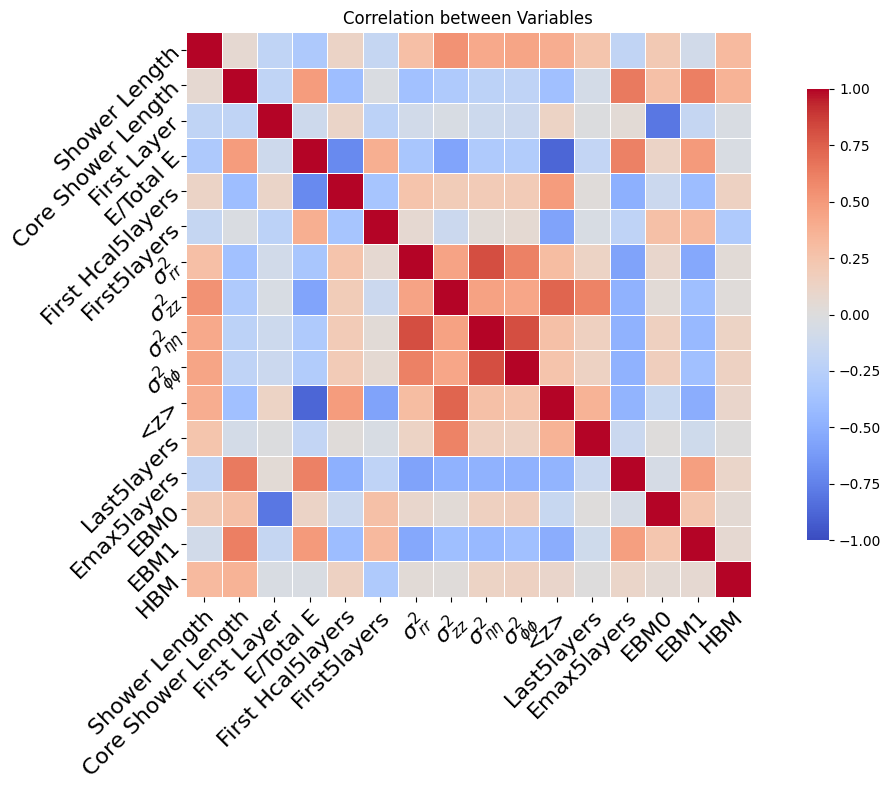

In [18]:
import seaborn as sns

correlation_matrix = df_combined[columns_for_training].corr()
latex_labels = [var_latex_map.get(col, col) for col in columns_for_training]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap without numbers in the cells
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
            vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": .8}, 
            xticklabels=latex_labels, yticklabels=latex_labels)
plt.title('Correlation between Variables')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize = 16)  # Rotate x-axis labels for readability
plt.yticks(rotation=45, ha='right', rotation_mode='anchor', fontsize = 16)  # Keep y-axis labels horizontal
plt.tight_layout()
plt.savefig("correlation.png", dpi = 300)
plt.show()

In [19]:
#filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]
filtered_data = df_combined[columns_for_training + ['label']].copy()
feature_importance_by_bin = {}
shap_values_by_bin = {}
mean_shap_values = {}

In [20]:
def maxbits(feat, maxbit=8, minbit=2):
    if ('firstlayer' in str(feat) or 'showerlength' in str(feat)) and feat.dtype == 'int32':
        return 6
    if feat.dtype == 'float32':
        if 'varzz' in str(feat) or 'varrr' in str(feat) or 'varpp' in str(feat):
            return 7
        elif 'meanz' in str(feat):
            return 12
        elif 'emax1layers' in str(feat) or 'emax3layers' in str(feat) or 'emax5layers' in str(feat):
            return 8
        elif 'last1layers' in str(feat) or 'last3layers' in str(feat) or 'last5layers' in str(feat):
            return 2
        elif 'first5layers' in str(feat) or 'first3layers' in str(feat) or 'first1layers' in str(feat):
            return 7
        elif 'firstHcal3layers' in str(feat) or 'firstHcal1layers' in str(feat) or 'firstHcal5layers' in str(feat):
            return 2
        elif 'varee' in str(feat):
            return 5
        else:
            return maxbit  
    if feat.dtype == 'int32' or feat.dtype == 'int64':
        unique_vals = np.unique(feat)
        nval = len(unique_vals)
        if nval == 1:  
            return 1
        for i in range(minbit, maxbit + 1):  
            if 2 ** i >= nval:
                return i
        return maxbit  
    if 'ebm1' in str(feat):
        return 10
    return minbit  # Fallback case

In [21]:
def quantize(feat, nbits, method, fmin, fmax):
    """Apply quantization to features."""
    nbins = 2 ** nbits
    bins = np.linspace(fmin, fmax, nbins + 1) if method == 'uniform' else np.percentile(feat, np.linspace(0, 100, nbins + 1))
    return np.digitize(feat, bins, right=True)

In [22]:
#nbits_dict = {col: maxbits(filtered_data[col]) for col in columns_for_training} #if using maxbit function

nbits_dict = { #if using manual declaration
    'cl3d_showerlength': 6,
    'cl3d_coreshowerlength': 6,
    'cl3d_firstlayer': 6,
    'cl3d_eot': 8,
    'cl3d_hoe': 8,
    'cl3d_firstHcal5layers': 8,
    'cl3d_varrr': 7,
    'cl3d_varzz': 7,
    'cl3d_varee': 5,
    'cl3d_varpp': 7,
    'cl3d_meanz': 12,
    'cl3d_first1layers': 7,
    'cl3d_first5layers': 7,
    'cl3d_last5layers': 6,
    'cl3d_emax5layers': 8,
    'cl3d_ebm0': 10,
    'cl3d_ebm1': 12,
    'cl3d_hbm': 10,
    #'cl3d_quality': 2
}
fmin_dict, fmax_dict = filtered_data[columns_for_training].min(), filtered_data[columns_for_training].max()

In [23]:
nbits_dict

{'cl3d_showerlength': 6,
 'cl3d_coreshowerlength': 6,
 'cl3d_firstlayer': 6,
 'cl3d_eot': 8,
 'cl3d_hoe': 8,
 'cl3d_firstHcal5layers': 8,
 'cl3d_varrr': 7,
 'cl3d_varzz': 7,
 'cl3d_varee': 5,
 'cl3d_varpp': 7,
 'cl3d_meanz': 12,
 'cl3d_first1layers': 7,
 'cl3d_first5layers': 7,
 'cl3d_last5layers': 6,
 'cl3d_emax5layers': 8,
 'cl3d_ebm0': 10,
 'cl3d_ebm1': 12,
 'cl3d_hbm': 10}

In [24]:
for col, nbits in nbits_dict.items():
    if nbits is None or not isinstance(nbits, int):
        print(f"Warning: Feature '{col}' has an invalid bit allocation: {nbits}")
        nbits_dict[col] = 6  # Assign a default value (e.g., 6 bits)
# --------------------- Train XGBoost Model ---------------------
X = filtered_data[columns_for_training]
y = filtered_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
best_params = {
    "objective": "binary:logistic",
    "n_estimators": 100,
    "max_depth": 4,
    "learning_rate": 0.005,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "gamma": 4.9,
    "reg_lambda": 1,
    "reg_alpha": 0.7,
    "n_jobs": 20
}
evals = [(X_train, y_train), (X_test, y_test)]
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4.9, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=20, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
# Train the model with tracking
eval_result = best_model.fit(X_train, y_train, eval_metric="auc", eval_set=evals, verbose=True)

# Accessing the evaluation results during training
train_auc = eval_result.evals_result()['validation_0']['auc']
test_auc = eval_result.evals_result()['validation_1']['auc']

[0]	validation_0-auc:0.96534	validation_1-auc:0.96085
[1]	validation_0-auc:0.98881	validation_1-auc:0.98629


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-auc:0.99050	validation_1-auc:0.98849
[3]	validation_0-auc:0.99125	validation_1-auc:0.98960
[4]	validation_0-auc:0.99125	validation_1-auc:0.98960
[5]	validation_0-auc:0.99123	validation_1-auc:0.98958
[6]	validation_0-auc:0.99125	validation_1-auc:0.98964
[7]	validation_0-auc:0.99122	validation_1-auc:0.98958
[8]	validation_0-auc:0.99125	validation_1-auc:0.98962
[9]	validation_0-auc:0.99333	validation_1-auc:0.99240
[10]	validation_0-auc:0.99331	validation_1-auc:0.99241
[11]	validation_0-auc:0.99330	validation_1-auc:0.99238
[12]	validation_0-auc:0.99328	validation_1-auc:0.99237
[13]	validation_0-auc:0.99337	validation_1-auc:0.99234
[14]	validation_0-auc:0.99335	validation_1-auc:0.99234
[15]	validation_0-auc:0.99334	validation_1-auc:0.99232
[16]	validation_0-auc:0.99335	validation_1-auc:0.99233
[17]	validation_0-auc:0.99335	validation_1-auc:0.99234
[18]	validation_0-auc:0.99335	validation_1-auc:0.99231
[19]	validation_0-auc:0.99341	validation_1-auc:0.99243
[20]	validation_0-

Saved: plots/roc_curve.png


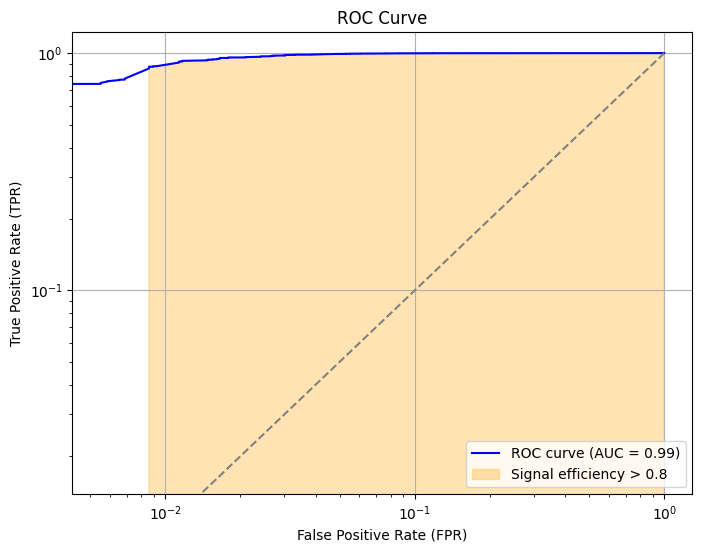

Partial AUC between TPR = 0.8 and TPR = 1: 0.9898


In [27]:
# --------------------- Evaluate Model ---------------------

y_pred_probs = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_probs, 0.8)

partial_auc = calculate_partial_auc(y_test, y_pred_probs, 0.8, 1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1: {partial_auc:.4f}")

In [28]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

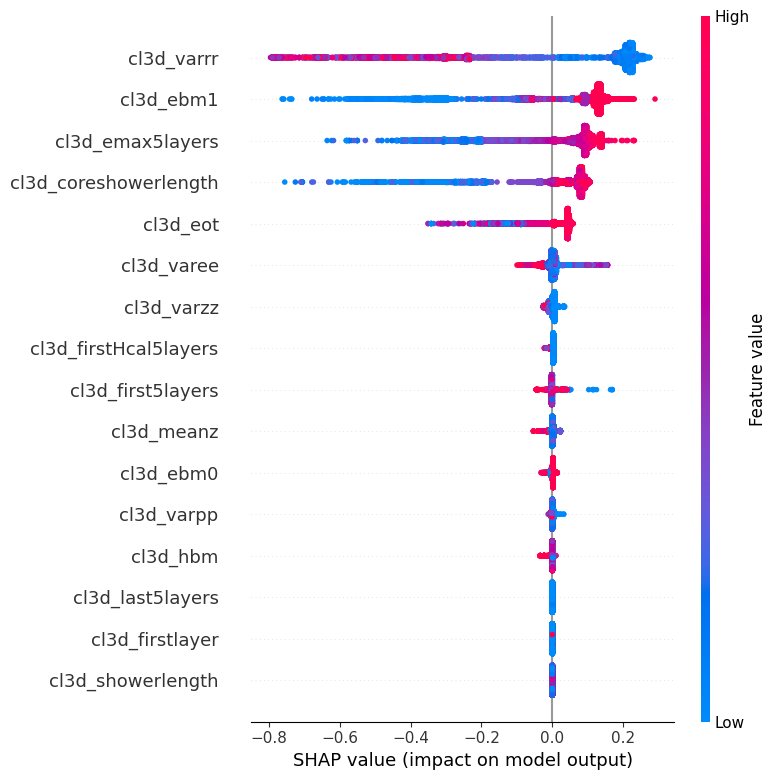

Saved: shap_summary.png


<Figure size 640x480 with 0 Axes>

In [29]:
# Generate SHAP summary plot
plt.figure()
plt.title(f"SHAP Summary")
shap.summary_plot(shap_values, X_test)
filename = f"shap_summary.png"
plt.savefig(filename, dpi=300)
print(f"Saved: {filename}")
plt.show()

In [30]:
y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Assuming binary classification
partial_auc = calculate_partial_auc(y_test, y_pred_probs, tpr_min=0.8, tpr_max=1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1: {partial_auc:.4f}")

Partial AUC between TPR = 0.8 and TPR = 1: 0.9898


Saved: plots/roc_curve.png


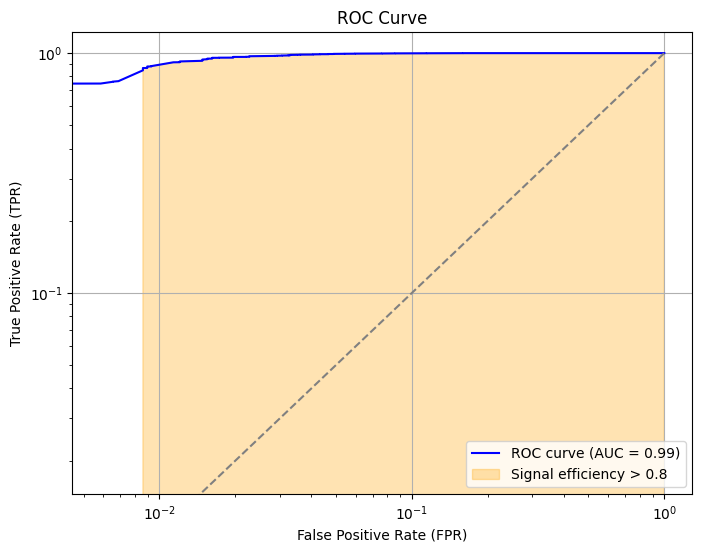

Partial AUC between TPR = 0.8 and TPR = 1 (quantized): 0.9898


In [31]:
# Quantize Features
quantized_data = filtered_data.copy()

# Apply quantization to each feature
for col in columns_for_training:
    nbits = nbits_dict[col]
    fmin = filtered_data[col].min()
    fmax = filtered_data[col].max()
    
    # Apply the quantization method (e.g., uniform binning)
    quantized_data[col] = quantize(filtered_data[col], nbits, method='uniform', fmin=fmin, fmax=fmax)

# --------------------- Train XGBoost Model with Quantized Data ---------------------
X_quantized = quantized_data[columns_for_training]
y = filtered_data['label']  # Target variable stays the same

X_train, X_test, y_train, y_test = train_test_split(X_quantized, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)

# --------------------- Evaluate Model ---------------------
y_pred_probs_quantized = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_pred_probs_quantized, 0.8)

partial_auc_quantized = calculate_partial_auc(y_test, y_pred_probs_quantized, 0.8, 1.0)
print(f"Partial AUC between TPR = 0.8 and TPR = 1 (quantized): {partial_auc_quantized:.4f}")

In [32]:
quantized_data

,cl3d_showerlength,cl3d_coreshowerlength,cl3d_firstlayer,cl3d_eot,cl3d_firstHcal5layers,cl3d_first5layers,cl3d_varrr,cl3d_varzz,cl3d_varee,cl3d_varpp,cl3d_meanz,cl3d_last5layers,cl3d_emax5layers,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,label
0,41,64,0,227,36,33,33,4,3,8,716,0,112,1024,1983,988,0
1,41,64,0,227,36,33,33,4,3,8,716,0,112,1024,1983,988,0
2,51,55,0,225,27,72,38,7,4,24,539,0,101,1024,2041,419,0
3,51,55,0,225,27,72,38,7,4,24,539,0,101,1024,2041,419,0
4,51,45,0,193,53,76,28,12,5,28,696,0,66,1024,1985,1016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40769,42,50,0,251,5,92,17,2,3,22,315,0,107,1024,2041,1006,1
40770,37,50,0,254,4,68,15,1,2,8,394,0,170,1024,1017,878,1
40771,49,55,0,252,3,82,32,3,9,26,367,0,139,1024,2033,74,1
40772,34,60,0,256,1,68,13,1,1,5,403,0,171,1024,1017,586,1


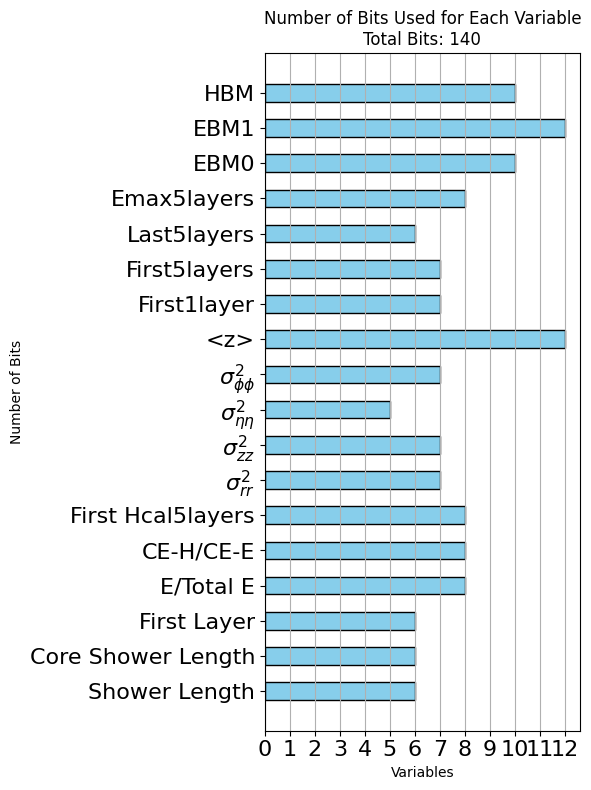

In [33]:
total_bits = sum(nbits_dict.values())
latex_labels = [var_latex_map.get(col, col) for col in nbits_dict.keys()]  # Use original name if no LaTeX is found

# Plot the number of bits used for each feature
plt.figure(figsize=(6, 8))
plt.barh(latex_labels, nbits_dict.values(), color='skyblue', edgecolor='black', height=0.5)
plt.xlabel('Variables')
plt.ylabel('Number of Bits')
plt.title(f'Number of Bits Used for Each Variable\nTotal Bits: {total_bits}')

# Rotate the feature names on the x-axis for readability
plt.yticks(fontsize=16)
plt.xticks(np.arange(0, max(nbits_dict.values()) + 1, 1), fontsize=16)
# Add gridlines for y-axis
plt.grid(axis='x')

# Adjust layout to prevent truncation of labels
plt.tight_layout()

# Save the plot with high resolution
plt.savefig('bits.png', dpi=300)

# Show the plot
plt.show()

In [34]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

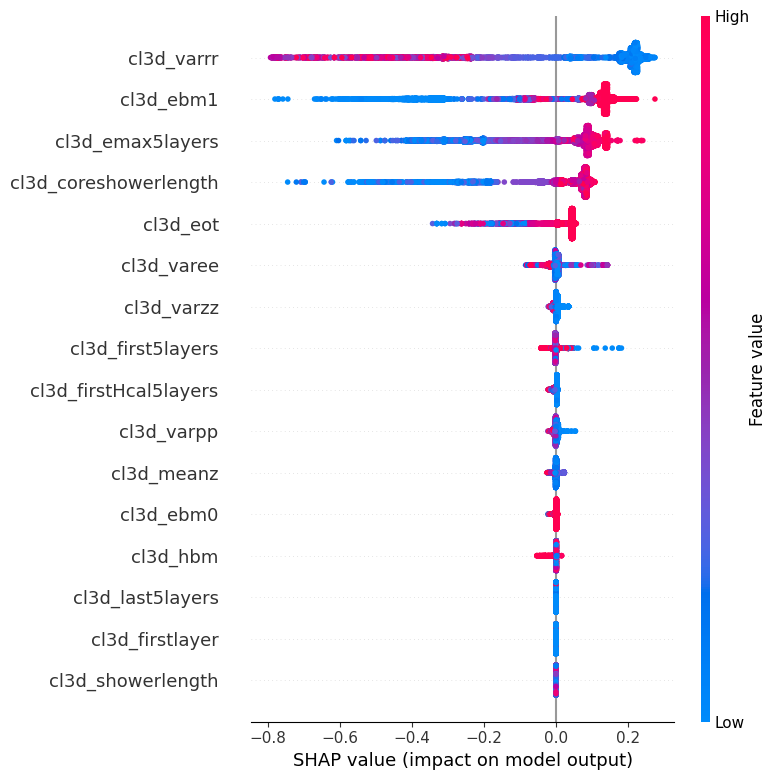

Saved: shap_summary.png


<Figure size 640x480 with 0 Axes>

In [35]:
# Generate SHAP summary plot
plt.figure()
plt.title(f"SHAP Summary")
shap.summary_plot(shap_values, X_test)
filename = f"shap_summary.png"
plt.savefig(filename, dpi=300)
print(f"Saved: {filename}")
plt.show()

In [36]:
# Create a conifer config for hardware synthesis
cfg = conifer.backends.vhdl.auto_config()  # Use VHDL for synthesis (can change to 'hls' if desired)

NameError: name 'conifer' is not defined

In [ ]:
best_model.get_booster().save_model("quantized_bdt.json")


In [ ]:
# Set the output directory for the synthesis process
os.makedirs('hdlprojects', exist_ok=True)
path = f'hdlprojects/prj_vhdl_{str(datetime.date.today())}_{time.time()}'
if os.path.exists(path):
    remove_folder(path)  # Clean up old project if exists
cfg['OutputDir'] = path
cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'  # Xilinx FPGA part (can be changed)
cfg['Precision'] = f'ap_fixed<{max(nbits_dict.values())},{0}>'  # Use maximum precision across all features
cfg['ProjectName'] = 'hgcal_vhdl'
cfg['ClockPeriod'] = 3  # Set clock period (change if necessary)

NameError: name 'time' is not defined

In [ ]:
# Use your existing dataset (`filtered_data`) and target (`label`)
X = filtered_data[columns_for_training]  # Use the features from your dataset
y = filtered_data['label']  # Use the target label from your dataset

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]  # Adjust based on your dataset
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train an XGBoost model
param = {'max_depth': 3, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 20  # Equivalent to the number of trees
bst = xgb.train(param, dtrain, num_round)

# Create a conifer config
cfg = conifer.backends.xilinxhls.auto_config()

converter = conifer.converters.convert_from_xgboost(bst, cfg)  # Create the converter object
# Create a conifer config
cfg = conifer.backends.xilinxhls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))

# Create and compile the model
model = conifer.converters.convert_from_xgboost(bst, cfg)
model.compile()


# Run HLS C Simulation and get the output
# xgboost 'predict' returns a probability like sklearn 'predict_proba'
# so we need to compute the probability from the decision_function returned
# by the HLS C Simulation
y_hls = expit(model.decision_function(X_test))
y_xgb = bst.predict(dtest)

# Synthesize the model
model.build()

Could not find ap_ headers (e.g., ap_fixed.h). None of XILINX_AP_INCLUDE, XILINX_HLS, XILINX_VIVADO are defined


Exception: Couldn't find Xilinx ap_ headers. Source the Vivado/Vitis HLS toolchain, or set XILINX_AP_INCLUDE environment variable.

In [ ]:
# other parts such as ROC data or SHAP plots here.

In [ ]:
print(dir(conifer.converters.xgboost))

['Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__xgb_version', 'convert', 'json', 'logger', 'logging', 'pandas', 'splitting_conventions', 'treeToDict', 'version', 'xgb']
